In [4]:
import pandas as pd
import numpy as np

In [5]:
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras

In [6]:
movie = pd.read_csv('movies.csv')
rating = pd.read_csv('ratings.csv')

In [7]:
movie['genres_split'] = movie['genres'].str.split('|')
genres_dummies = movie['genres_split'].explode().str.get_dummies().groupby(level=0).sum()
movie = movie[['movieId', 'title']].join(genres_dummies)

In [8]:
rating.drop(columns=['timestamp'], inplace=True)
movie = movie.drop(columns=['(no genres listed)'])

In [9]:
movie_1 = movie

In [10]:
movie_v1 = movie_1.drop(columns=['title'])

In [11]:
movie_v1

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62419,209159,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
62420,209163,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62421,209169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
data_all = movie_v1.merge(rating, on='movieId')

In [13]:
user1 = data_all[data_all['userId'] == 1]
user1.shape

(70, 22)

In [14]:
user1.nunique()

movieId        70
Action          2
Adventure       2
Animation       2
Children        2
Comedy          2
Crime           2
Documentary     2
Drama           2
Fantasy         2
Film-Noir       2
Horror          2
IMAX            1
Musical         2
Mystery         2
Romance         2
Sci-Fi          2
Thriller        2
War             2
Western         2
userId          1
rating          9
dtype: int64

### Env

In [301]:
class DQL_model:
    def __init__(self, state_size, action_size, 
            epsilon= 0.6,gamma= 0.75 , epsilon_decay=0.99, learning_rate=0.01, batch_size=32, tau=0.05):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.tau = tau
        self.user_satisfaction, self.stability = 0, 0
        
        self.memory = deque(maxlen=2000)
                
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_dim= self.state_size, activation= 'relu'))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(32, activation= 'relu'))
        model.add(keras.layers.Dense(self.action_size))
        
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate= self.learning_rate))
        
        return model
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size, size=5, replace=False)
        
        state = state.astype(np.float32)
        act_values = self.model.predict(np.reshape(state, [1,self.state_size]))
        
        top_5_indices = np.argsort(act_values[0])[-5:][::-1]
        
        return top_5_indices
    
    def update_target_model(self):
        model_w =  self.model.get_weights()
        target_model_w = self.target_model.get_weights()
        
        target_model_w = [self.tau * model_w[i] + (1 - self.tau) * target_model_w[i] for i in range(len(target_model_w))]  
        
        self.target_model.set_weights(target_model_w)
    
    def adjust_parameters(self):
        if self.user_satisfaction < 3:
            self.epsilon = min(0.9, self.epsilon + 0.05)
        if self.user_satisfaction > 3:
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
            
        if self.stability < 0.4:
            self.gamma = max(0.9, self.gamma * 1.05)
        if self.stability > 1:
            self.gamma = min(0.5, self.gamma - 0.05)

    def train(self):
        if len(self.memory) < self.batch_size:
            return
                
        minibatch = random.sample(self.memory, self.batch_size)
        
        for state, action, reward, next_state in minibatch:

            current_q_values = self.model.predict(np.reshape(state, [1, self.state_size]))

            next_q_values = self.target_model.predict(np.reshape(next_state, [1, self.state_size]))

            # Bellman
            target_q_value = reward + self.gamma * np.amax(next_q_values[0])

            target_f = current_q_values.copy()
            target_f[0][action] = target_q_value
            
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)      
        
        self.update_target_model()
            
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
        
        self.adjust_parameters()
        
        

In [340]:
class Env:
    def __init__(self,data_movie, data, user_id, dqn_model):
        # load data users and movies
        self.data = data
        self.user_id = user_id
        self.data_movie = data_movie
        self.dqn_model = dqn_model  # dqn model
        
        # get user
        self.user_data = self.data[self.data['userId'] == self.user_id]
        self.user_data.drop(columns=['userId'], inplace=True)
        
        # get genres
        self.genres = self.user_data.columns[1:-1]
        self.user_data.drop(columns=['movieId'], inplace=True)
        
        # storage data
        self.storage = self.user_data[self.genres]
        self.memory = None
        self.movie_suggestions = None
                
        # rating movie
        self.skip_count = 0
        self.max_skip = 10
        
        self.total_reward = [0]
        self.list_user_satisfaction = []
        
        self.get_memory_from_user_data()   
        self.dqn_model.user_satisfaction, self.dqn_model.stability = self.calc_user_statisfaction()    
         
        self.reset()
        
    def reset(self): 
        self.movie_suggestions = self.data_movie.sample(10)
        self.skip_count = 0
        print('Reset')
        return self.movie_suggestions
    
    def suggest_next_movie(self):
        if self.skip_count == self.max_skip or self.memory is None:
            self.reset()
        else:    
            self.movie_suggestions = None
            
            current_state = self.memory[self.genres].values.astype(np.float32)
                
            suggested_genres_indices = self.dqn_model.act(current_state)
                            
            for genre_index in suggested_genres_indices:
                filtered_movie = self.data_movie[self.data_movie[self.genres[genre_index]] == 1]
                
                if not filtered_movie.empty:
                    print(f"genre: {self.genres[genre_index]}")
                    self.movie_suggestions = pd.concat([self.movie_suggestions, filtered_movie.sample(1)])
                else:
                    self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(1)])
            
            self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(5)])
            
            return self.movie_suggestions
        
    
    def storage_data(self):
        if self.memory is not None:
            new_row = pd.DataFrame([self.memory[self.genres].values], columns=self.genres)
            self.storage = pd.concat([self.storage, new_row], ignore_index=True)
        return self.storage
    
    def reward_movie(self, rating):
        reward = 0
        
        # skip
        penalty_skip =  self.skip_count * 0.5
        reward -= penalty_skip        

        # user satisfaction
        if self.dqn_model.user_satisfaction > 3:
            reward += rating * 1.2
        elif self.dqn_model.user_satisfaction < 2:
            reward += rating * 0.8
        
        # rating
        if rating < 3:
            reward -= rating
        else:
            reward += rating
        
        print(f"user satisfaction: {self.dqn_model.user_satisfaction}")
        print(f"stability: {self.dqn_model.stability}")
        
        self.dqn_model.user_satisfaction, self.dqn_model.stability = self.calc_user_statisfaction()
            
        return reward 
    
    def rating_movie(self, rating= None):
        if rating is not None and self.memory is not None:
            
            self.memory = self.memory[self.genres]
            
            state = self.memory.values.astype(np.float32)
            
            action = self.dqn_model.act(state)
            
            reward = self.reward_movie(rating)
            
            self.total_reward.append(reward + self.total_reward[-1])
            
            next_state = state
            
            self.dqn_model.remember(state, action, reward, next_state)
            
            self.dqn_model.train()
            
            self.skip_count = 0
            
            return self.memory
    
    def step(self, index = None, skip= False):
        
        if skip:
            self.skip_count += 1
            if self.skip_count == self.max_skip:
                self.reset()   
                     
        if index is not None:
                                    
            self.selected_movie = self.movie_suggestions.iloc[index]
            
            self.memory = self.selected_movie
            
            return self.selected_movie
        
    def get_memory_from_user_data(self):
        for _, row in self.user_data.iterrows():
            state = row[self.genres].values
            
            action = [index for index, value in enumerate(state) if value == 1]
            
            if action:
                action = random.choice(action)
            
            rating = row['rating']
            
            reward = self.reward_movie(rating)
            
            self.total_reward.append(reward + self.total_reward[-1])
            
            random_index = np.random.randint(0, len(self.user_data))
            next_state = self.user_data.iloc[random_index][self.genres].values
            
            self.dqn_model.remember(state, action, reward, next_state)
            
        self.dqn_model.train()
    
    def calc_user_statisfaction(self):
        list_rewards = [self.total_reward[i] - self.total_reward[i-1] for i in range(1, len(self.total_reward))]
        
        user_satisfaction = np.mean(list_rewards)
        
        user_satisfaction = np.clip(user_satisfaction, 0, 5)
        
        self.list_user_satisfaction.append(user_satisfaction)
        
        stability = np.std(list_rewards)
        
        return user_satisfaction, stability

In [341]:
state_size=19
action_size=19

In [342]:
dql = DQL_model(state_size, action_size)
env = Env(movie,data_all, user_id= -1, dqn_model= dql)

for _ in range(150):
    skip = np.random.choice([True, False])
    if skip:
        print(f"{_}: skip")
    # skip = True
    # skip = False
    choice = None
    
    if not skip:
        choice = np.random.randint(0,5)
        
    env.step(choice, skip= skip)
    
    if not skip:
        rating = np.random.randint(1,6)
        # rating = 5
            
        env.rating_movie(rating= rating)
        
        print(f"{_}: choice moive:{choice}, rating:{rating}")
    
    env.suggest_next_movie()

Reset
0: skip
Reset
user satisfaction: nan
stability: nan
1: choice moive:4, rating:4
genre: Musical
genre: Comedy
genre: Adventure
genre: Fantasy
genre: Mystery
2: skip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_24700\3365008592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.user_data.drop(columns=['userId'], inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_24700\3365008592.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
genre: Horror
genre: Fantasy
genre: Comedy
genre: Sci-Fi
genre: Western
user satisfaction: nan
stability: nan
3: choice moive:0, rating:4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
genre: Horror
genre: Fantasy
genre: War
genre: Musical
genre: Comedy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
user satisfaction: 4.0
stability: 0.0
4: choice moive:3, rating:3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
genre: Horror
genre: Fantasy
genre: Children
genre: Western
genre: Action
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
user satisfaction: 3.75
stability: 0.25
5: choice moive:3, rating:2
genre: Drama
genre: Romance
genre: Western
genre: Fantasy
genre: Comedy
6: skip
genre: Drama
genre: Film-Noir
genre: Mystery
genre: Sci-Fi
genre: Musical
user satisfaction: 4.7
stability: 1.3589211407093005
7: choice moive:1, rating:1
genre: Horror
genre: Crime
genre: Documentary
genre: Thriller
genre: Comedy
user satisfaction: 3.625
stability: 2.202697210240209
8: choice moive:0, rating:2
ge

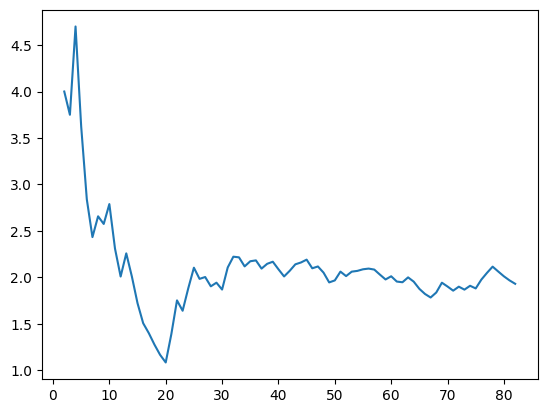

In [343]:
import matplotlib.pyplot as plt

plt.plot( range(len(env.list_user_satisfaction)), env.list_user_satisfaction)
plt.show()

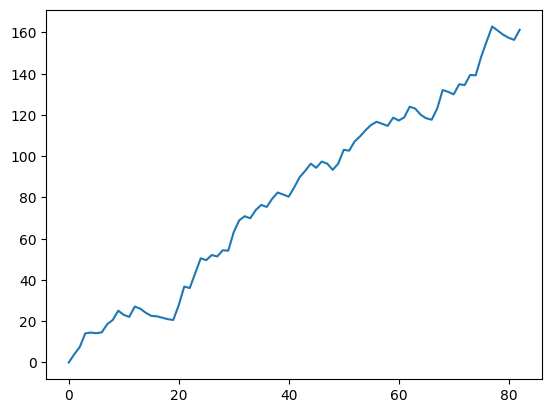

In [344]:
plt.plot(range(len(env.total_reward)), env.total_reward)

In [345]:
len(dql.memory)

82

In [346]:
env.calc_user_statisfaction()

(np.float64(1.967073170731707), np.float64(3.2961934763709544))

In [347]:
# env.suggest_next_movie()

In [348]:
# env.step(1)

In [349]:
# title = movie[movie['movieId'] == env.selected_movie['movieId']]
# title

In [350]:
# env.rating_movie(rating=2)

In [351]:
# env.memory.values

In [352]:
# env.storage_data()
# env.storage

In [353]:
# env.suggest_next_movie()

In [354]:
    # def train(self):
    #     if len(self.memory) < self.batch_size:
    #         return
        
    #     minibatch = random.sample(self.memory, self.batch_size)
    #     cumulative_reward = 0 
        
    #     for state, action, reward, next_state in minibatch:
            
    #         cumulative_reward += reward
            
    #         target = reward
    #         if next_state is not None:
    #             target += reward + self.gamma*np.amax(self.target_model.predict(np.reshape(next_state, [1,self.state_size]))[0])
                        
    #         target_f = self.model.predict(np.reshape(next_state, [1,self.state_size])) 
            
    #         target_f[0][action] = target
            
    #         history =  self.model.fit(np.reshape(state, [1,self.state_size]), target_f, epochs=1)
            
    #     loss = history.history['loss'][0]
            
    #     self.loss_history.append(loss)
                     
    #     self.epsilon *= self.epsilon_decay
        
    #     self.update_target_model()